In [4]:
!pip3 install git+https://github.com/pashna/gbm_custom_loss.git

# Loading Boston Dataset

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
X, y = load_boston(True)
print("X shape = {}, y shape = {}".format(X.shape, y.shape))
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("Train {}| Test {}".format(len(X_train), len(X_test)))

X shape = (506, 13), y shape = (506,)
Train 379| Test 127


/home/newuser/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


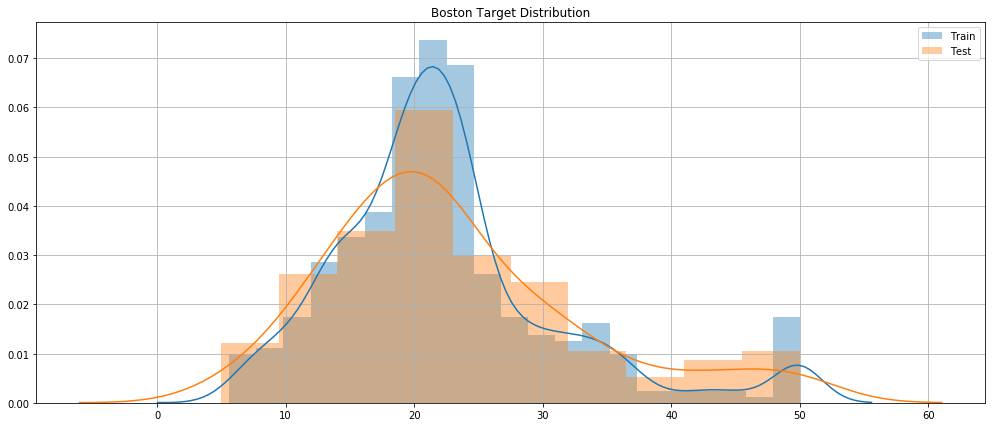

In [3]:
plt.figure(figsize=(17, 7))
plt.title("Boston Target Distribution")
sns.distplot(y_train, label="Train")
sns.distplot(y_test, label="Test")
plt.legend()
plt.grid()

# Define a Piecewise MSE

In [112]:
from gbm_custom_loss.catboost.piecewise_loss.piecewise_mse import PiecewiseMSE
piecewise_mse = PiecewiseMSE({ 
                             (-1e20, -10): {"coef": 13}, 
                             (-10, 5): {"coef": 0.1},
                             (5, 1e20): {"coef": 25}
                            })
print(piecewise_mse)

PiecewiseMSE:
(-1e+20, -10) -> coef=13
(-10, 5) -> coef=0.1
(5, 1e+20) -> coef=25


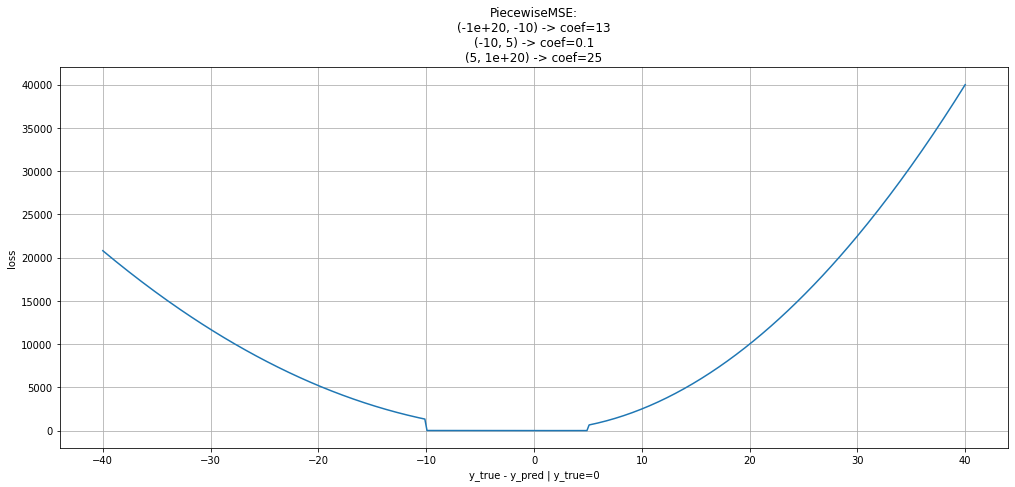

In [113]:
from gbm_custom_loss.utils.visualization import plot_loss
x, y = plot_loss(piecewise_mse)
_, ax = plt.subplots(figsize=(17, 7))
ax.set_title(str(piecewise_mse))
ax.plot(x, y)
ax.set_xlabel("y_true - y_pred | y_true=0")
ax.set_ylabel("loss")
ax.grid()

# Define a Biased Piecewise MSE

In [119]:
from gbm_custom_loss.catboost.piecewise_loss.biased_piecewise_mse import BiasedPiecewiseRMSE
biased_piecewise_mse = BiasedPiecewiseRMSE({ 
                                     (-1e20, -10): {"coef": 13,
                                                   "bias": 10}, 
                                     (-10, 5): {"coef": 0.4,
                                               "bias": 30,},
                                     (5, 1e10): {"coef": 25,
                                                 "bias": -55}
                                    })
print(biased_piecewise_mse)

BiasedPiecewiseMSE:
(-1e+20, -10) -> coef=13|bias=10
(-10, 5) -> coef=0.4|bias=30
(5, 10000000000.0) -> coef=25|bias=-55


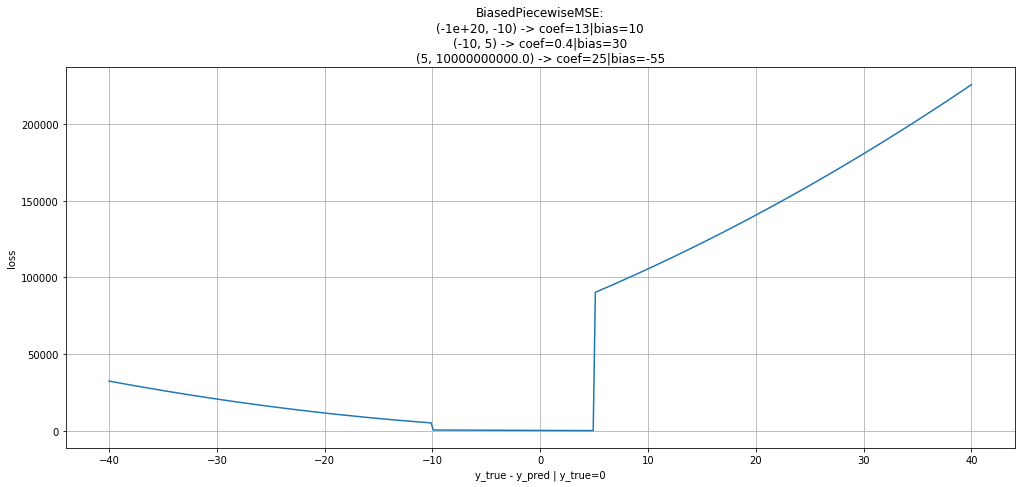

In [120]:
x, y = plot_loss(biased_piecewise_mse)
_, ax = plt.subplots(figsize=(17, 7))
ax.set_title(str(biased_piecewise_mse))
ax.plot(x, y)
ax.set_xlabel("y_true - y_pred | y_true=0")
ax.set_ylabel("loss")
ax.grid()

# Training Catboost with PiecewiseMSE

Let's first assume that our goal is not to predict the price of hoisung Y, but instead we need to predict as many positions as possible for which:
* The predicted price is no more than 10 higher the actual price
* The predicted price is no more than 5 lower than actual price

In [121]:
class IntervalMetric(object):
    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        approx = approxes[0]
        
        within_interval_n = 0.
        weight_sum = 0.
        for i in range(len(approx)):
            if ((target[i] - approx[i]) < 5) and ((target[i] - approx[i]) > -10):
                within_interval_n += 1
                
            weight_sum = 1.0 if weight is None else weight[i]
            
        return within_interval_n/len(approx), weight_sum
    
    def get_final_error(self, error_sum, weight):
        return error_sum/weight
    
metric = IntervalMetric()

In [136]:
from catboost import CatBoostRegressor

results = []
predict = {}
for loss in ["RMSE", piecewise_mse, biased_piecewise_mse]:
    cbr = CatBoostRegressor(loss_function=loss,
                            eval_metric=metric,
                            iterations=2000,
                            silent=True,
                            use_best_model=True)
    cbr.fit(X_train, y_train, 
            eval_set=(X_test, y_test))
    
    loss_name = str(loss).split(":")[0]
    predict[loss] = cbr.predict(X_test)
    results.append([loss_name, cbr.best_score_['validation']['IntervalMetric']])

In [137]:
import pandas as pd
pd.DataFrame(results, columns=["Loss", "Interval Metric"]).round(3)

,Loss,Interval Metric
0,RMSE,0.961
1,PiecewiseMSE,0.969
2,BiasedPiecewiseMSE,0.975


for better results, the parameters (biases and coefs) should be tunned together with hyperparameters of the model